# Bioacoustic analysis of DAS-recorded data

Author: [Léa Bouffaut](mailto:lb736'cornell.edu)
https://www.birds.cornell.edu/ccb/lea-bouffaut/


OptaSense QuantX data

### Initialization of the libraries

In [8]:
# Get the DAS4Whales package
!pip3 install 'git+https://github.com/leabouffaut/DAS4Whales.git'

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/leabouffaut/DAS4Whales.git to /private/var/folders/r3/47wgjrrx71vcvyvv6mmbfjkm0000gp/T/pip-req-build-tjzqa1q_
  Running command git clone --filter=blob:none --quiet https://github.com/leabouffaut/DAS4Whales.git /private/var/folders/r3/47wgjrrx71vcvyvv6mmbfjkm0000gp/T/pip-req-build-tjzqa1q_
  Resolved https://github.com/leabouffaut/DAS4Whales.git to commit 10621744243a09d715cfecc27c239cd97033457c
  Preparing metadata (setup.py) ... done


## Get a DAS data
Here, we check if file example "filename" already exists else, download a .hdf5 file from the OOI DAS experiment
Experiment information can be found at:  https://oceanobservatories.org/pi-instrument/rapid-a-community-test-of-distributed-acoustic-sensing-on-the-ocean-observatories-initiative-regional-cabled-array/

Files are ~850 MB so the download can take a while

In [9]:
import wget
import os

filename = 'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T020002Z.h5'

if os.path.exists(filename) == True:
    print(filename, ' already exists in path')
else:
    url = 'http://piweb.ooirsn.uw.edu/das/data/Optasense/NorthCable/TransmitFiber/' \
          'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-03T15_06_51-0700/' \
          'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T022302Z.h5'
           
    das_example_file = wget.download(url)
    print(['Downloaded: ', das_example_file])

North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T020002Z.h5  already exists in path


## Get information on the DAS data

In [10]:
import das4whales as dw
import scipy.signal as sp
import numpy as np

# Read HDF5 files and access metadata
# Get the acquisition parameters for the data folder
fs, dx, nx, ns, gauge_length, scale_factor = dw.data_handle.get_acquisition_parameters(filename)

print('Sampling frequency: ', fs, ' Hz')
print('Gauge length: ', gauge_length, ' m')
print('File duration: ', ns/fs, ' s')
print('Channel spacing: ', dx, ' m')
print('Number of channels: ', nx)
print('Number of time samples: ', ns)

Sampling frequency:  200.0  Hz
Gauge length:  51.04762  m
File duration:  60.0  s
Channel spacing:  2.0419047  m
Number of channels:  32600
Number of time samples:  12000


## Select the desired channels and channel interval

In [4]:
selected_channels_m = [20000, 65000, 10]  # list of values in meters corresponding to the starting,
                                          # ending and step wanted channels along the FO Cable
                                          # selected_channels_m = [ChannelStart_m, ChannelStop_m, ChannelStep_m]
                                          # in meters

selected_channels = [int(selected_channels_m // dx) for selected_channels_m in
                     selected_channels_m]  # list of values in channel number (spatial sample) corresponding to the starting, ending and step wanted
                                           # channels along the FO Cable
                                           # selected_channels = [ChannelStart, ChannelStop, ChannelStep] in channel
                                           # numbers

print('Begin channel #:', selected_channels[0], 
      ', End channel #: ',selected_channels[1], 
      ', step: ',selected_channels[2], 
      'equivalent to ',selected_channels[2]*dx,' m')


Begin channel #: 9794 , End channel #:  31833 , step:  4 equivalent to  8.167618751525879  m


## Create the filters to condition the signal

In [5]:
# Create band-pass filter for the TX plots
sos_bpfilt = dw.dsp.butterworth_filter([5, [10, 30], 'bp'], fs)

# Create high-pass filter
sos_hpfilt = dw.dsp.butterworth_filter([2, 5, 'hp'], fs)

## Load raw DAS data

In [6]:
# Load DAS data
tr, time, dist, fileBeginTimeUTC = dw.data_handle.load_das_data(filename, fs, dx, selected_channels, scale_factor)

## Apply band-pass filter and plot

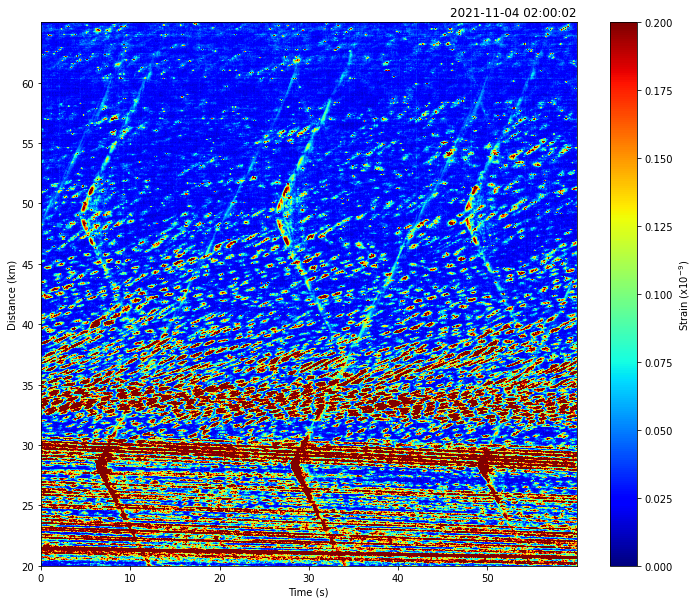

In [7]:
# band-pass filter
trf = sp.sosfiltfilt(sos_bpfilt, tr, axis=1)

# Plot
dw.plot.plot_tx(trf, time, dist, fileBeginTimeUTC, fig_size=(12, 10))

## Apply f-k and plot

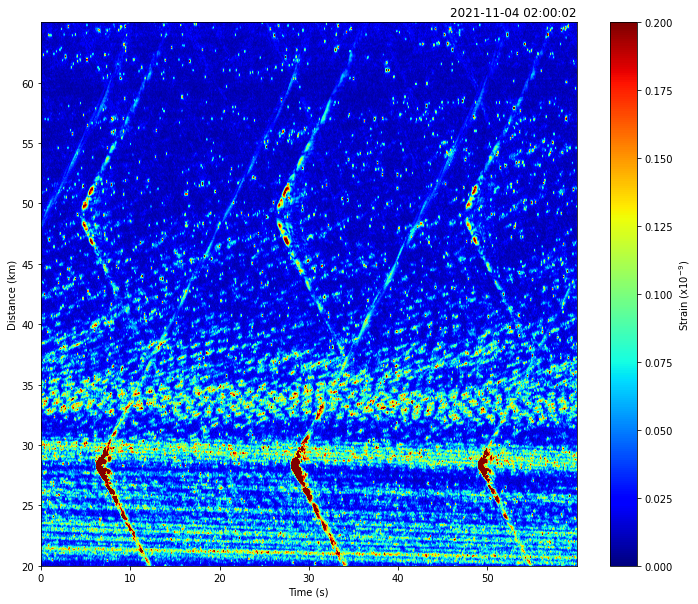

In [8]:
# FK filter
trf_fk = dw.dsp.fk_filtering(trf, selected_channels, dx, fs, c_min=1450, c_max=3000)

# Plot
dw.plot.plot_tx(trf_fk, time, dist, fileBeginTimeUTC, fig_size=(12, 10))

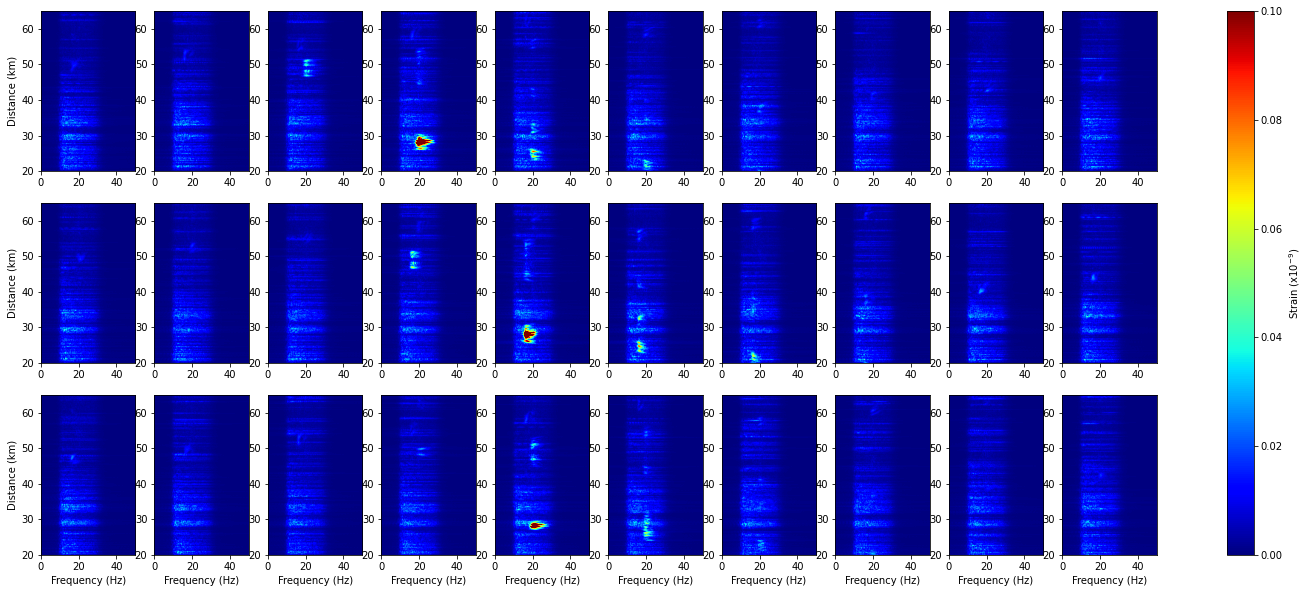

In [11]:
# Spatio-spectral plot
dw.plot.plot_fx(trf_fk, dist, fs, win_s=2,  nfft=512, f_min=0, f_max=50, fig_size=(25, 10))

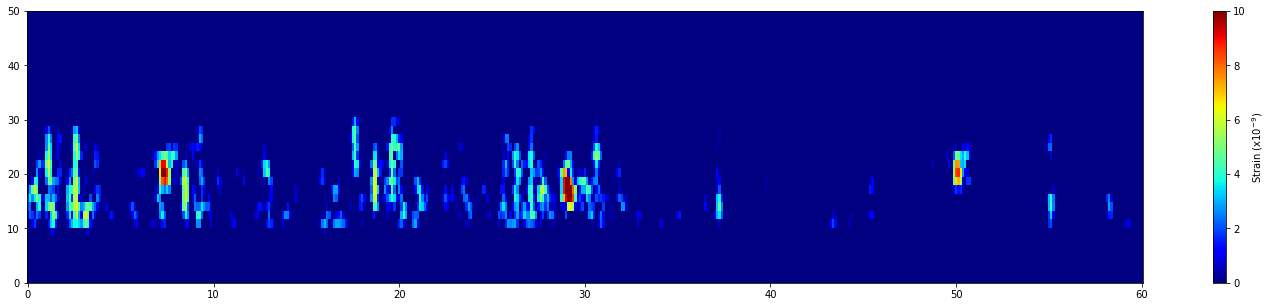

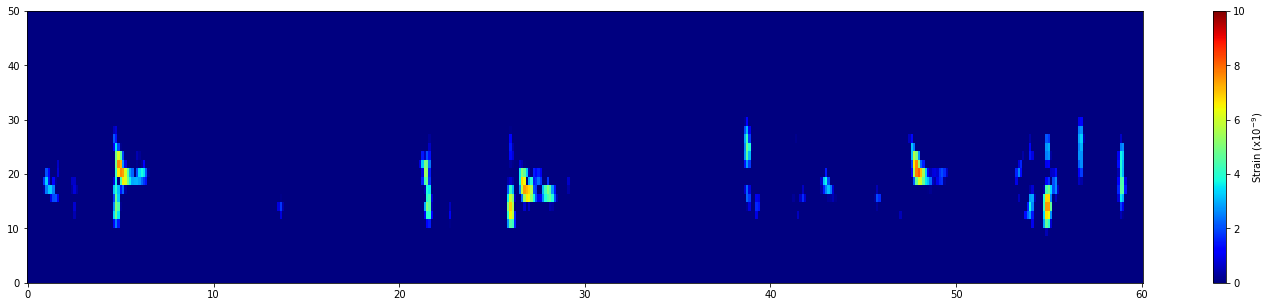

In [17]:
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np

def get_spectrogram(waveform, nfft=128, overlap_pct=0.8):
    
    # Example ----
    # p = get_spectrogram(
    #    x, fs, 
    #    win_length_s=data_settings['spec_settings']['win_len'],
    #    overlap_pct=data_settings['spec_settings']['win_overlap_prc'])
         
    spectrogram = np.abs(librosa.stft(
        y=waveform, n_fft=nfft,
        hop_length=int(np.floor(nfft*(1-overlap_pct)))))   
    
    return spectrogram

def plot_spectrogram(spectrogram, fs, duration, scale='lin', fig_size=(25, 5), ):         
    
    log_spec = 10*np.log10(spectrogram*10**9)
    
    # Axis
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    tt = np.linspace(0, duration, num=width)
    ff = np.linspace(0, fs/2, num=height)
    
    fig, ax = plt.subplots(figsize=fig_size)
    
    # Scale for the frequency axis
    ax.set_yscale(scale)
    
    shw = ax.pcolormesh(tt, ff, log_spec, cmap = "jet", vmin=-0, vmax=10)
    ax.set_ylim(0,50)
    
    # Colorbar
    bar = fig.colorbar(shw, aspect=20)
    bar.set_label('Strain (x$10^{-9}$)')
    plt.show()
    

# band-pass filter
#trf = sp.sosfiltfilt(sos_hpfilt, tr, axis=1)

# read one channel only as audio
sel_chan = 27000 # (m)
idx = (np.abs(dist - sel_chan)).argmin()

# Spectrogram
p = get_spectrogram(trf_fk[idx,:])
plot_spectrogram(p, fs,  ns/fs, scale='linear')

# read one channel only as audio
sel_chan = 50000 # (m)
idx = (np.abs(dist - sel_chan)).argmin()

# Spectrogram
p = get_spectrogram(trf_fk[idx,:])
plot_spectrogram(p, fs,  ns/fs, scale='linear')


# Play audio
Audio(data=trf_fk[idx,:], rate=fs*10)